In [ ]:
import nltk
import pandas as pd
import numpy as np
import re
import codecs

## Our Dataset: Disasters on social media
The dataset comprises of over 10,000 tweets retrieved with a variety of searches like “ablaze”, “quarantine”, and “pandemonium”, then noted whether the tweet referred to a disaster event (as opposed to a joke with the word or a movie review or something non-disastrous).

In [ ]:
def load_data(input_path):
  output_path = f"{input_path[:-4]}_clean{input_path[-4:]}"
  input_file = codecs.open(input_path, "r",encoding='utf-8', errors='replace')
  output_file = open(output_path, "w")

  for line in input_file:
      out = line
      output_file.write(line)

  questions = pd.read_csv(output_path)
  questions.columns=['text', 'choose_one', 'class_label']
  print(questions.head())

  questions = questions[questions.class_label!=2]
  print(questions.class_label.unique())
  questions.loc[questions.choose_one=='Relevant','choose_one'] = 'Disaster'
  questions.loc[questions.choose_one=='Not Relevant','choose_one'] = 'Not Disaster'
  print(questions.head())
  print(questions.choose_one.unique())
  return questions

In [ ]:
questions = load_data("/content/concrete_NLP_tutorial/socialmedia_relevant_cols.csv")

                                                text choose_one  class_label
0                 Just happened a terrible car crash   Relevant            1
1  Our Deeds are the Reason of this #earthquake M...   Relevant            1
2  Heard about #earthquake is different cities, s...   Relevant            1
3  there is a forest fire at spot pond, geese are...   Relevant            1
4             Forest fire near La Ronge Sask. Canada   Relevant            1
[1 0]
                                                text choose_one  class_label
0                 Just happened a terrible car crash   Disaster            1
1  Our Deeds are the Reason of this #earthquake M...   Disaster            1
2  Heard about #earthquake is different cities, s...   Disaster            1
3  there is a forest fire at spot pond, geese are...   Disaster            1
4             Forest fire near La Ronge Sask. Canada   Disaster            1
['Disaster' 'Not Disaster']


In [ ]:
questions.describe()

class_label
count  10843.000000
mean       0.429494
std        0.495027
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

Let's use a few regular expressions to clean up pour data, and save it back to disk for future use

In [ ]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv",index=False)
questions.head()

text choose_one  class_label
0                 just happened a terrible car crash   Disaster            1
1  our deeds are the reason of this  earthquake m...   Disaster            1
2  heard about  earthquake is different cities, s...   Disaster            1
3  there is a forest fire at spot pond, geese are...   Disaster            1
4             forest fire near la ronge sask  canada   Disaster            1

In [ ]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

text  ... class_label
10838  1 3  earthquake in 9km ssw of anza california ...  ...           1
10839   evacuation order lifted for town of roosevelt     ...           1
10840  see the 16yr old pkk suicide bomber who detona...  ...           1
10841  to conference attendees! the blue line from th...  ...           1
10842  the death toll in a  is suicide car bombing on...  ...           1

[5 rows x 3 columns]

### Data Overview

Let's look at our class balance.

In [ ]:
clean_questions.groupby("class_label").count()

text  choose_one
class_label                  
0            6186        6186
1            4657        4657

### Data Preparation

Our data is clean, now it needs to be prepared.

Now that our inputs are more reasonable, let's transform our inputs in a way our model can understand. This implies:
- Tokenizing sentences to a list of separate words
- Creating a train test split
- Inspecting our data a little more to validate results

In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

text  ...                                             tokens
0                 just happened a terrible car crash  ...          [just, happened, a, terrible, car, crash]
1  our deeds are the reason of this  earthquake m...  ...  [our, deeds, are, the, reason, of, this, earth...
2  heard about  earthquake is different cities, s...  ...  [heard, about, earthquake, is, different, citi...
3  there is a forest fire at spot pond, geese are...  ...  [there, is, a, forest, fire, at, spot, pond, g...
4             forest fire near la ronge sask  canada  ...      [forest, fire, near, la, ronge, sask, canada]

[5 rows x 4 columns]

### Inspecting our dataset a little more

In [ ]:
all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154329 words total, with a vocabulary size of 18082
Max sentence length is 34


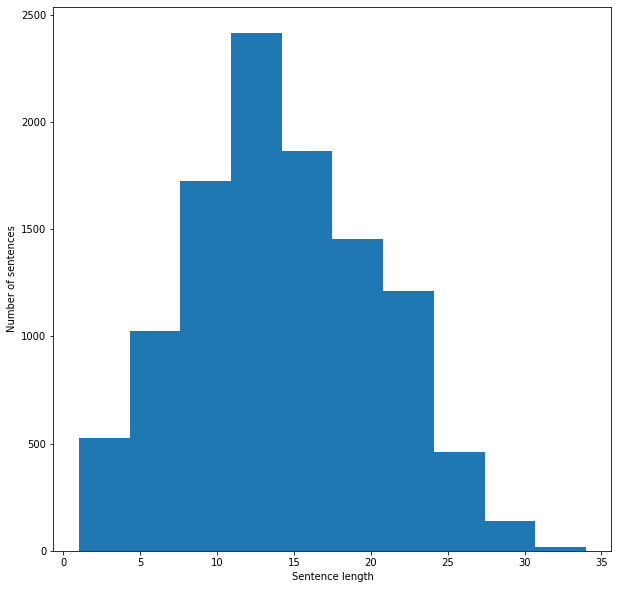

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

## On to the Machine Learning
Now that our data is clean and prepared, let's dive in to the machine learning part.

## Enter embeddings
 
A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.

The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

 ## Bag of words

 Now that we have our training reviews tidied up, how do we convert them to some kind of numeric representation for machine learning? One common approach is called a Bag of Words. The Bag of Words model learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears. For example, consider the following two sentences:

Sentence 1: "The cat sat on the hat"

Sentence 2: "The dog ate the cat and the hat"

From these two sentences, our vocabulary is as follows:

{ the, cat, sat, on, hat, dog, ate, and }

To get our bags of words, we count the number of times each word occurs in each sentence. In Sentence 1, "the" appears twice, and "cat", "sat", "on", and "hat" each appear once, so the feature vector for Sentence 1 is:

{ the, cat, sat, on, hat, dog, ate, and }

Sentence 1: { 2, 1, 1, 1, 1, 0, 0, 0 }

Similarly, the features for Sentence 2 are: { 3, 1, 0, 0, 1, 1, 1, 1}

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool
    
    emb = count_vectorizer.fit_transform(data)
    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings.

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the embeddings
Now that we've created embeddings, let's visualize them and see if we can identify some structure. In a perfect world, our embeddings would be so distinct that are two classes would be perfectly separated. Since visualizing data in 18k dimensions is hard, let's project it down to 2.

{0, 1}


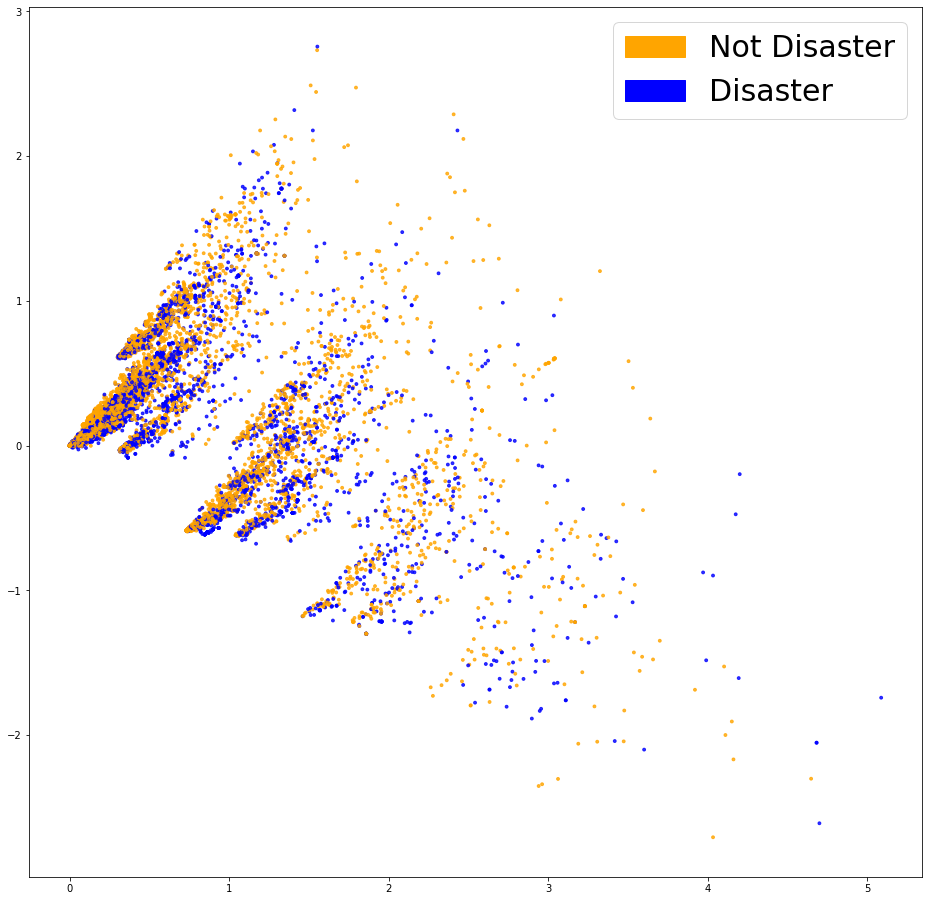

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        
        lsa_scores = lsa.transform(test_data)
        # color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        # color_column = [color_mapper[label] for label in test_labels]
        print(set(test_labels))
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Not Disaster')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. Let's see if we can still fit a useful model on them.

### Fitting a classifier
Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

### Evaluation
Let's start by looking at some metrics to see if our classifier performed well at all.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.770, precision = 0.770, recall = 0.770, f1 = 0.770


### Inspection
A metric is one thing, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

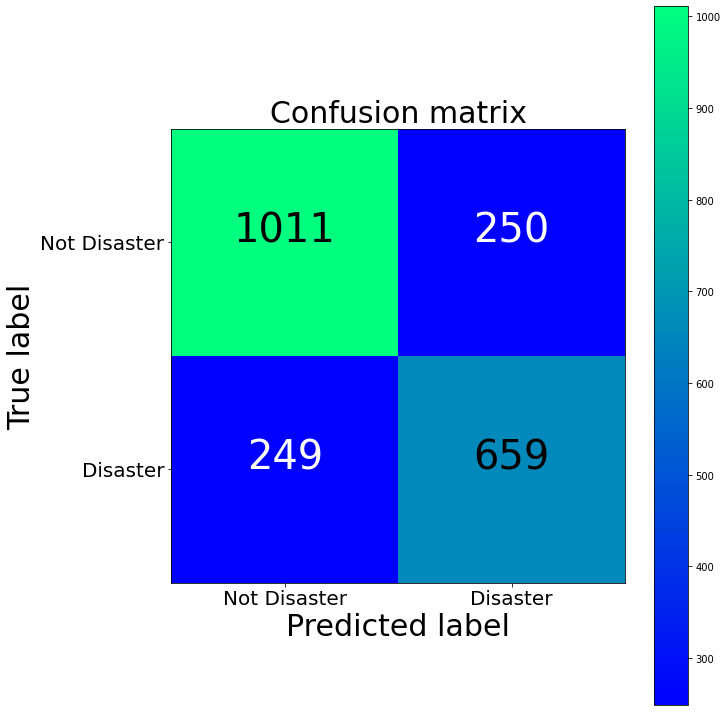

[[1011  250]
 [ 249  659]]


In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Disaster','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

### Further inspection
Let's look at the features our classifier is using to make decisions.

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

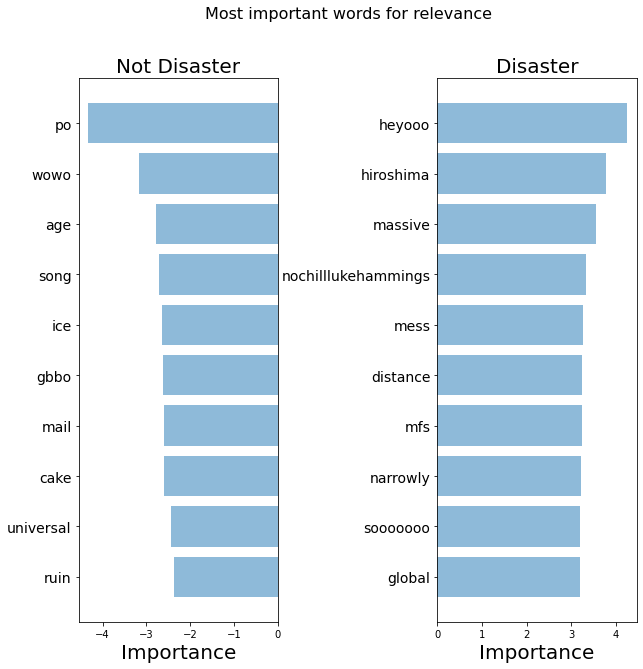

In [47]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Not Disaster', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Our classifier correctly picks up on some patterns (hiroshima, massacre), but clearly seems to be overfitting on some irellevant terms (heyoo, x1392)

## TFIDF Bag of Words

Let's try a slightly more subtle approach. On top of our bag of words model, we use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.

### What is TFIDF?
TF-IDF stands for term frequency-inverse document frequency. TF-IDF weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

Term Frequency (TF): is a scoring of the frequency of the word in the current document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. The term frequency is often divided by the document length to normalize.

**TF** = (No of times term "t" appears in the document)/(Total number of 

terms in the document)

Inverse Document Frequency (IDF): is a scoring of how rare the word is across documents. IDF is a measure of how rare a term is. Rarer the term, more is the IDF score.

**IDF** = log ((Total no of documents)/(No of documents with term "t" in it))

Thus, **TF-IDF = TF * IDF**



In [ ]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

{0, 1}


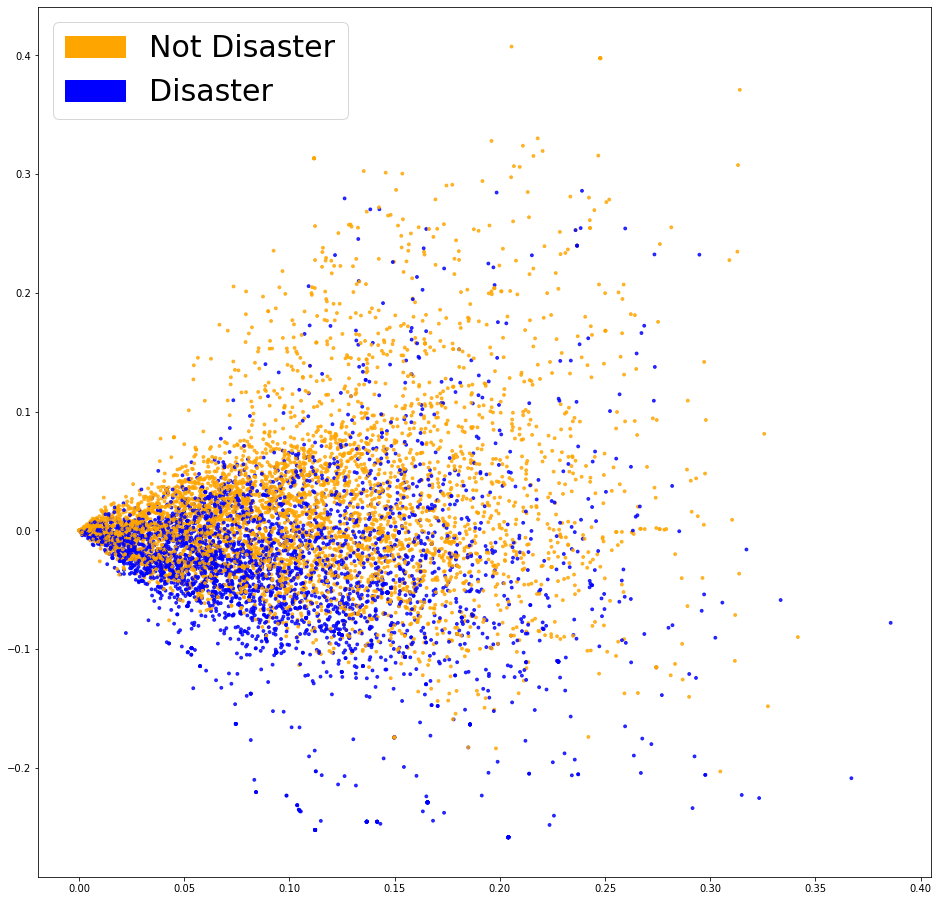

In [ ]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

These embeddings look much more separated, let's see if it leads to better performance.

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.772, precision = 0.773, recall = 0.772, f1 = 0.772


The results are a little better, let's see if they translate to an actual difference in our use case.

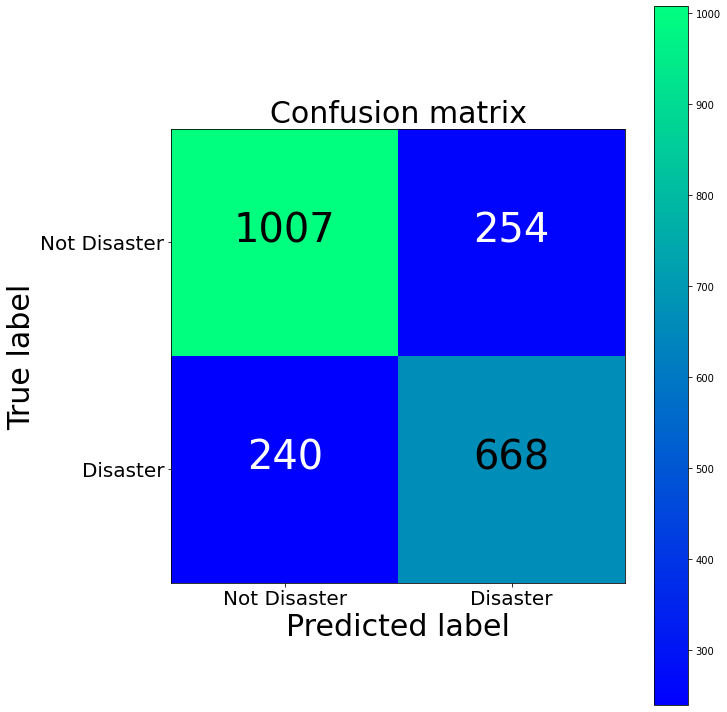

TFIDF confusion matrix
[[1007  254]
 [ 240  668]]
BoW confusion matrix
[[1011  250]
 [ 249  659]]


In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not Disaster','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

### Looking at important coefficients for linear regression

In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

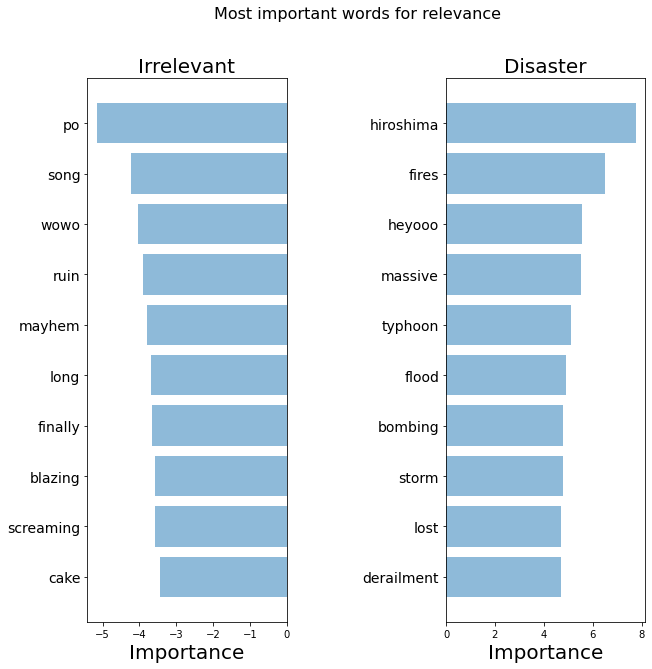

In [ ]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

The words it picked up look much more relevant! Although our metrics on our held out validation set haven't increased much, we have much more confidence in the terms our model is using, and thus would feel more comfortable deploying it in a system that would interact with customers.

## Capturing semantic meaning
Our first models have managed to pick up on high signal words. However, it is unlikely that we will have a training set containing all relevant words. To solve this problem, we need to capture the semantic meaning of words. 

### Enter word2vec
Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-11-05 09:56:30--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.50.74
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.50.74|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

{0, 1}


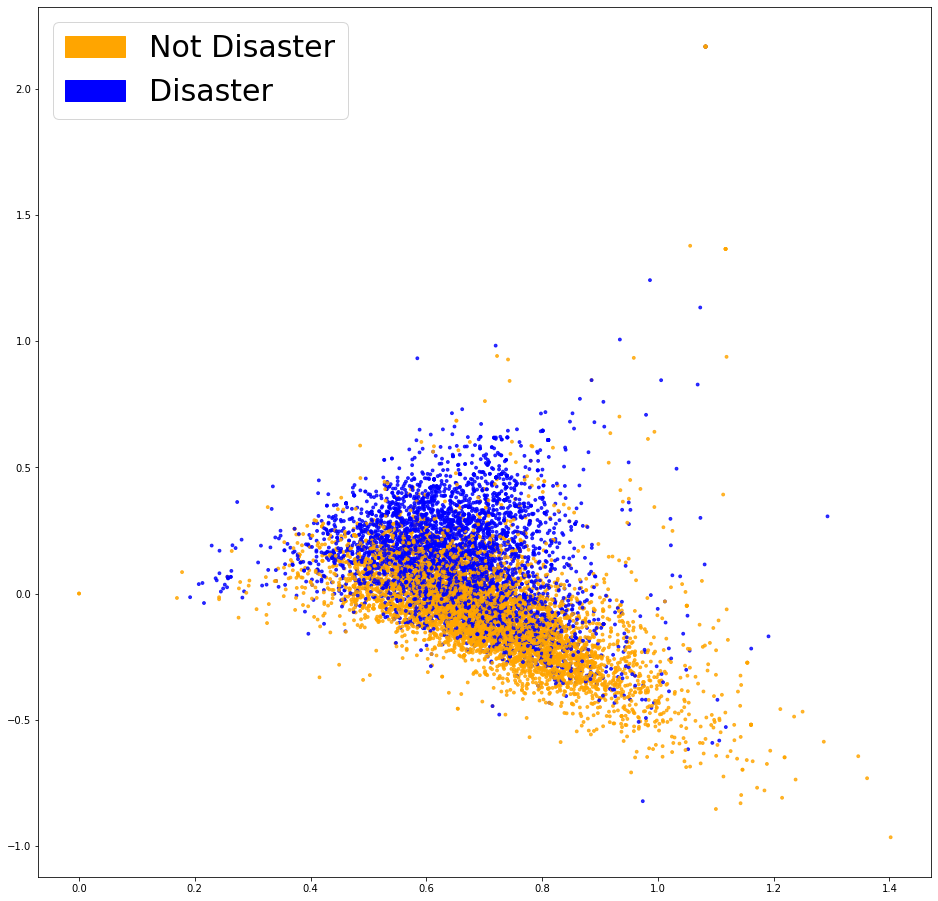

In [ ]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

These look much more separated, let's see how our logistic regression does on them!

In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.787, precision = 0.787, recall = 0.787, f1 = 0.787


Still getting better, let's plot the confusion matrix

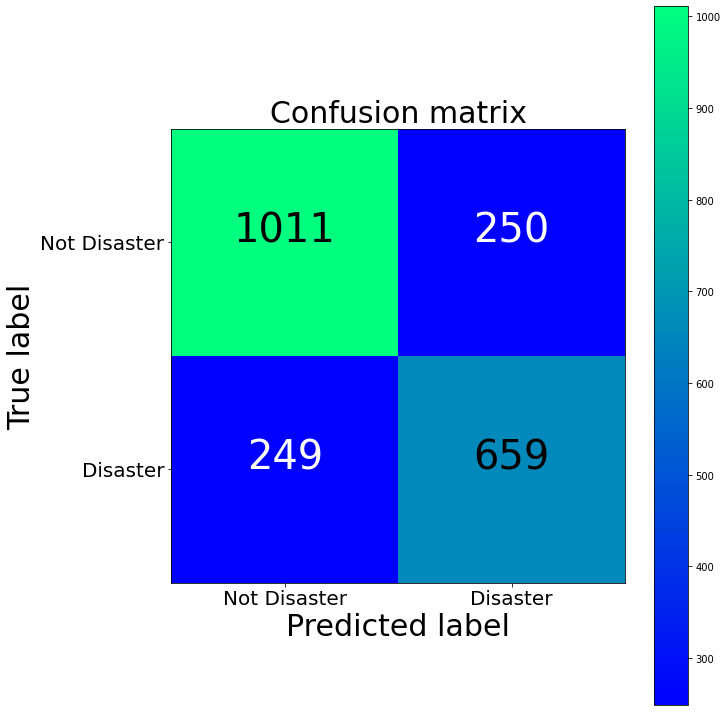

Word2Vec confusion matrix
[[1031  230]
 [ 231  677]]
TFIDF confusion matrix
[[1007  254]
 [ 240  668]]
BoW confusion matrix
[[1011  250]
 [ 249  659]]


In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Disaster','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Our model is strictly better in all regards than the first two models, this is promissing!

### Further inspection
Since our model does not use a vector with one dimension per word, it gets much harder to directly see which words are most relevant to our classification. In order to provide some explainability, we can leverage a black box explainer such as LIME.

In [ ]:
!pip install lime

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [41]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Not Disaster","Disaster"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [42]:
visualize_one_exp(X_test_data, y_test_data, 65)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Index: 65
True class: Not Disaster


In [43]:
visualize_one_exp(X_test_data, y_test_data, 50)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Index: 50
True class: Disaster


In [ ]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Not Disaster',
    1: 'Disaster',
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

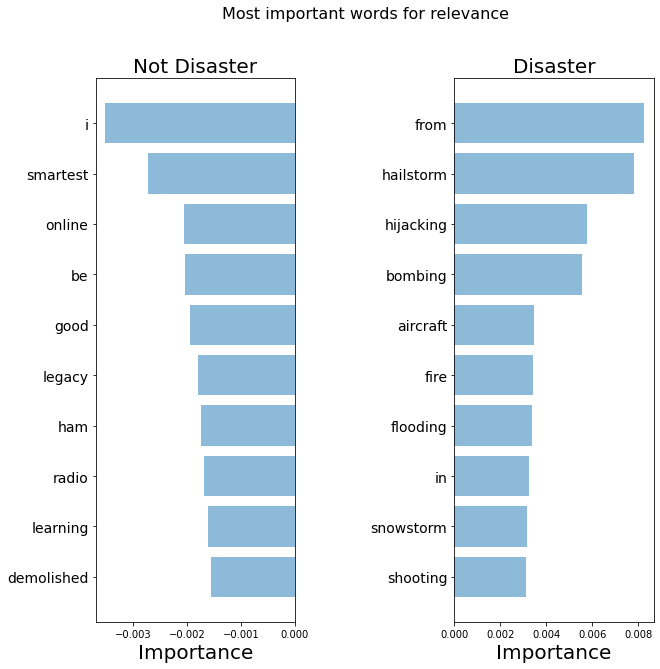

In [48]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Disaster']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Disaster']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Disaster']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Disaster']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Looks like very relevant words are picked up! This model definitely seems to make decisions in a very understandable way.